In [12]:
import os
import yaml
from scipy import interpolate

import torch
from matplotlib import pyplot as plt
import numpy as np
from src.forward_models.reactdiff import ReactDiffSolver as ReactDiffSolverPDE

In [13]:
# load experiment parameters
with open(os.path.join('..', 'params.yaml'), 'r') as fd:
    params_data = yaml.safe_load(fd)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_samples = 50
reactdiff_solver = ReactDiffSolverPDE(
        t0=params_data["t_span"][0],
        t1=params_data["t_span"][1],
        dx=params_data["mesh_step"],
        noise_std=params_data["sigma"],
        len_episode=params_data["len_episode"],
        ode_stepsize=params_data["ode_stepsize"],
        method=params_data["ode_solver"],
        device=device,
    )
a = (
    torch.rand(1, 1, device=device).expand(n_samples, 1)
    * (params_data["a_range"][1] - params_data["a_range"][0])
    + params_data["a_range"][0]
)# a shape (batch, 1)
b = (
    torch.rand(1, 1, device=device).expand(n_samples, 1)
    * (params_data["b_range"][1] - params_data["b_range"][0])
    + params_data["b_range"][0]
)# b shape (batch, 1)

k = params_data["k"] #currently one-to-one mapping 
if isinstance(k, list):
    # random sample from k[0], k[1] bounds
    noisy_samples = params_data["n_stoch_samples"]
    k = (
        torch.rand(a.shape[0], noisy_samples, 1, device=device) * (k[1] - k[0])
        + k[0]
    ).unsqueeze(2).view(-1, 1)
    a = a.unsqueeze(1).repeat(1, noisy_samples, 1).view(-1, 1)
    b = b.unsqueeze(1).repeat(1, noisy_samples, 1).view(-1, 1)
else:
    k = torch.tensor(k, device=device).expand(n_samples, 1) 
    noisy_samples = 1
params = torch.cat([a, b, k], dim=1) # shape (batch, 3)
init_cond = torch.rand(
    n_samples,
    2,
    params_data["grid_size"],
    params_data["grid_size"],
    device=device,
).unsqueeze(1).repeat(1, noisy_samples, 1, 1, 1).flatten(0, 1) # initial conditions shape (batch, 2, grid_size, grid_size), all uniform random in [0, 1]
# batchify and solve
print(init_cond.shape, params.shape)
with torch.no_grad():
    res_x = reactdiff_solver(
        init_conds=init_cond,
        params=params[:, :-1], # without k param.
    )


torch.Size([250, 2, 32, 32]) torch.Size([250, 3])


In [15]:
with torch.no_grad():
    res_y = reactdiff_solver(
        init_conds=init_cond,
        params=params,
    )

In [16]:
print(res_x["x"].shape, res_y["x"].shape)
print(res_x["init_conds"].shape, res_y["init_conds"].shape)
print(res_x["params"].shape, res_y["params"].shape)

torch.Size([250, 2, 32, 32, 16]) torch.Size([250, 2, 32, 32, 16])
torch.Size([250, 2, 32, 32]) torch.Size([250, 2, 32, 32])
torch.Size([250, 2]) torch.Size([250, 3])


In [17]:
print(res_x["x"].shape)
Y_hat = res_x["x"].view(-1, noisy_samples, 2, 32, 32, 16)
Y = res_y["x"].view(-1, noisy_samples, 2, 32, 32, 16)
Y_hat.shape, Y.shape

torch.Size([250, 2, 32, 32, 16])


(torch.Size([50, 5, 2, 32, 32, 16]), torch.Size([50, 5, 2, 32, 32, 16]))

7
21.46155


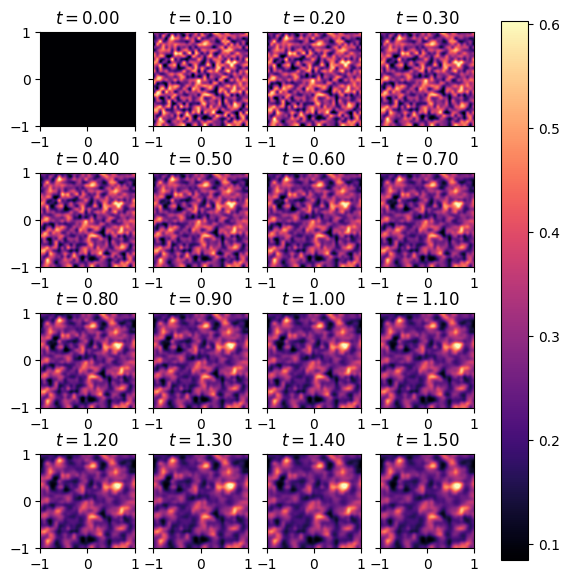

21.574566


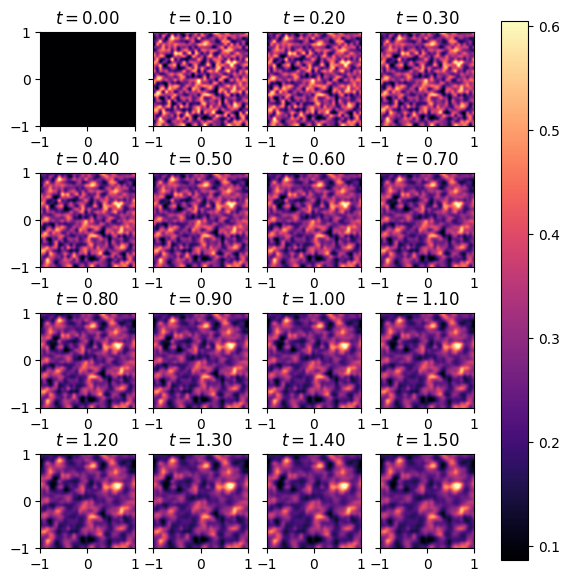

21.511497


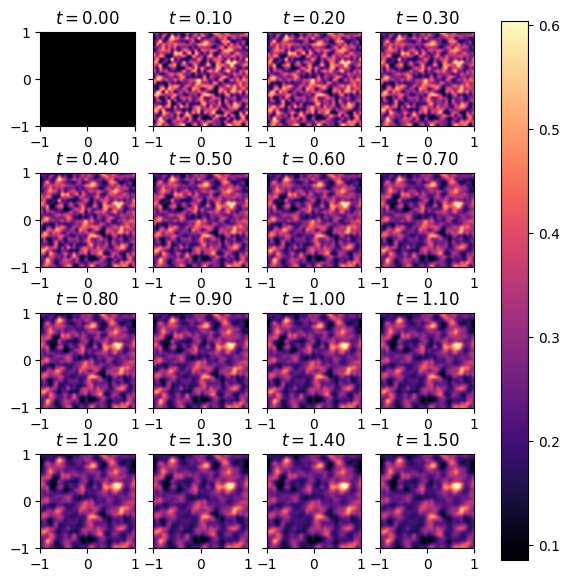

21.552044


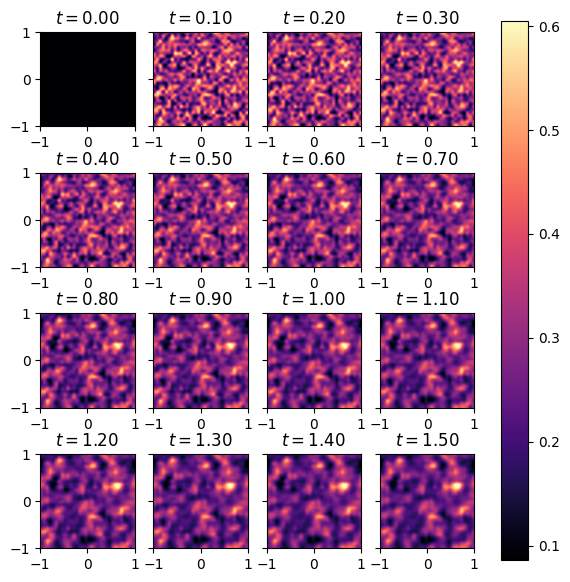

21.626259


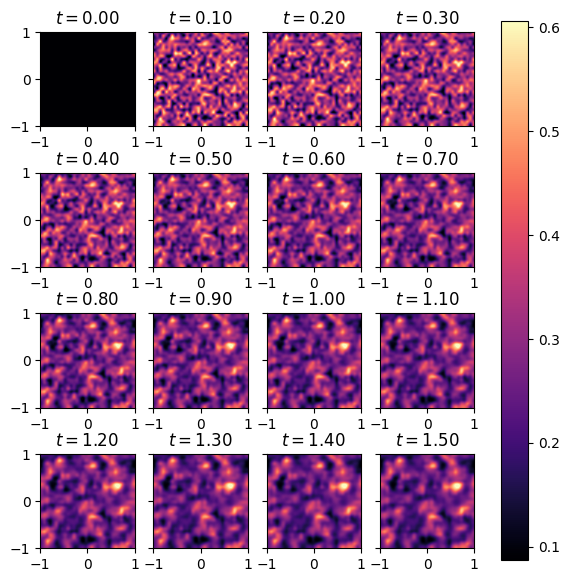

In [18]:

# plot
sample_idx = np.random.randint(0, Y.shape[0])
print(sample_idx)
for i in range(noisy_samples):
    U = Y_hat[sample_idx, i, 0].detach().cpu().numpy()
    U_Y = Y[sample_idx, i, 0].detach().cpu().numpy()
    fig, axes = plt.subplots(4, 4, figsize=(7, 7), sharey=True)
    
    for i in range(16):
        ax = axes.flat[i]
        time_index = i*int(U.shape[-1]/15)
        field = U[:, :,time_index] - U_Y[:,:,time_index]
        pos = ax.imshow(field, cmap="magma", interpolation='spline16', extent=[-1, 1, -1, 1])
        ax.set_title(f'$t={reactdiff_solver.t[time_index]:.2f}$')

    fig.colorbar(pos, ax=axes.ravel().tolist())
    print(np.linalg.norm(U - U_Y))
    plt.show()
    


7


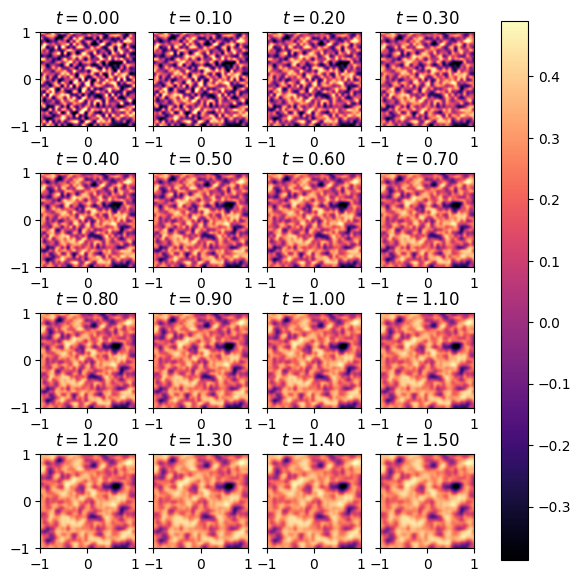

7


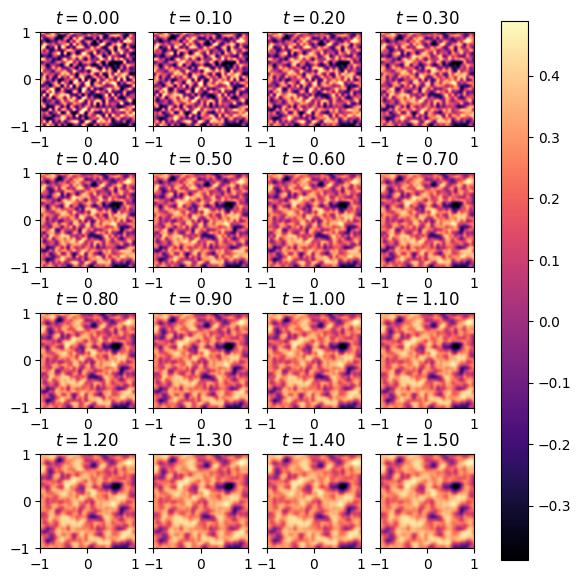

7


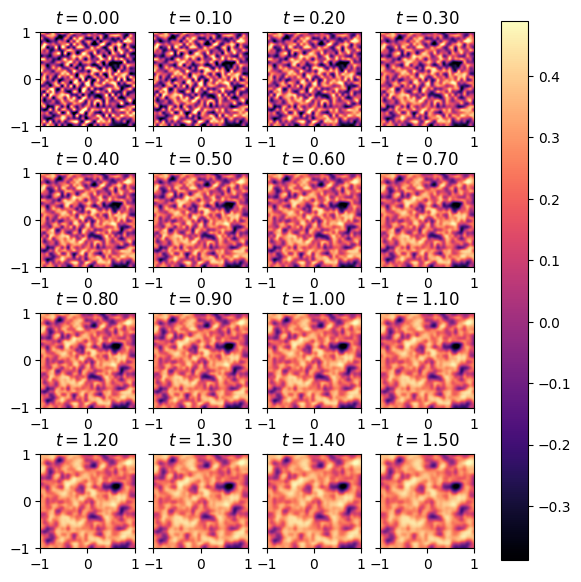

7


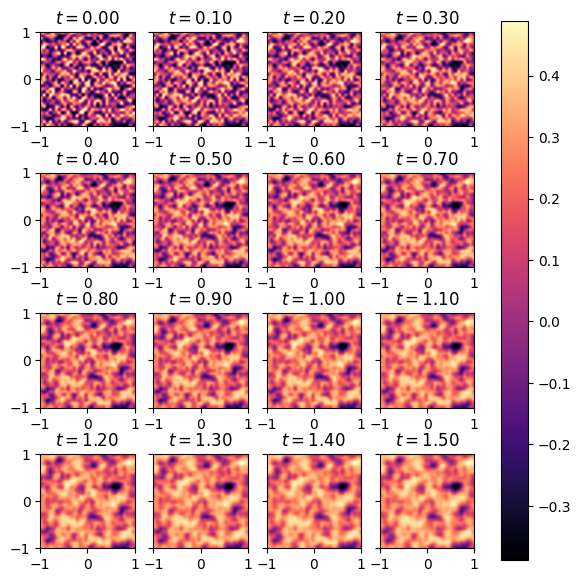

7


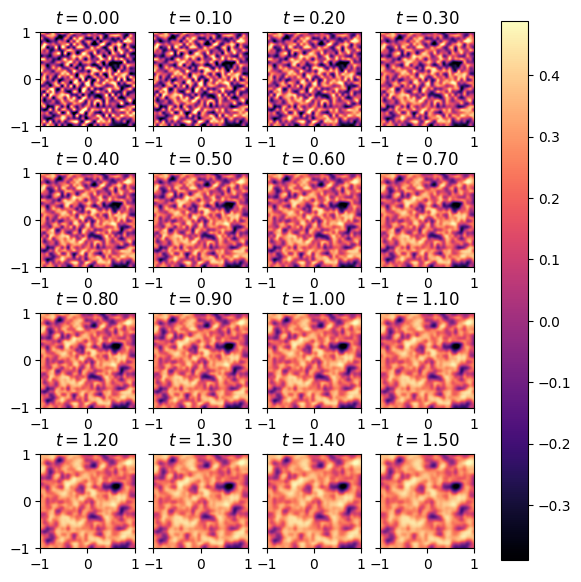

In [19]:
for i in range(noisy_samples):
    U = Y_hat[sample_idx, i, 0].detach().cpu().numpy()
    U_Y = Y[sample_idx, i, 0].detach().cpu().numpy()
    fig, axes = plt.subplots(4, 4, figsize=(7, 7), sharey=True)
    print(sample_idx)
    for i in range(16):
        ax = axes.flat[i]
        time_index = i*int(U.shape[-1]/15)
        field = U_Y[:,:,time_index]
        pos = ax.imshow(field, cmap="magma", interpolation='spline16', extent=[-1, 1, -1, 1])
        ax.set_title(f'$t={reactdiff_solver.t[time_index]:.2f}$')

    fig.colorbar(pos, ax=axes.ravel().tolist())
    plt.show()

In [20]:
assert not torch.isclose(res_x["x"], res_y["x"]).all()

## Check dataset

In [21]:
path_file = "../../../../datasets/forward_models/reactdiff/training/data_6d7ca3fe37f2ac0950134a4dc31a7b48.pt"
dataset = torch.load(path_file)

In [22]:
dataset["x"].shape, dataset["init_conds"].shape, dataset["params"].shape

(torch.Size([500, 2, 32, 32, 16]),
 torch.Size([500, 2, 32, 32]),
 torch.Size([500, 3]))

In [23]:
#dataset["init_conds"].flatten(start_dim=0, end_dim=1).shape

In [24]:
ab_params = dataset["params"][:, :2]#[:,:, :2].flatten(start_dim=0, end_dim=1)
init_conds = dataset["init_conds"]#.flatten(start_dim=0, end_dim=1)
ab_params.shape, init_conds.shape

(torch.Size([500, 2]), torch.Size([500, 2, 32, 32]))

In [25]:
reactdiff_solver = ReactDiffSolverPDE(
        t0=params_data["t_span"][0],
        t1=params_data["t_span"][1],
        dx=params_data["mesh_step"],
        noise_std=params_data["sigma"],
        len_episode=params_data["len_episode"],
        ode_stepsize=params_data["ode_stepsize"],
        method=params_data["ode_solver"],
        device=device,
    )
with torch.no_grad():
    res_x = reactdiff_solver(
        init_conds=init_conds,
        params=ab_params, # without k param.
    )

In [26]:
Y = dataset["x"]#.flatten(start_dim=0, end_dim=1)
Y.shape, res_x["x"].shape

(torch.Size([500, 2, 32, 32, 16]), torch.Size([500, 2, 32, 32, 16]))

In [27]:
#.flatten(start_dim=0, end_dim=1)
assert torch.isclose(dataset["init_conds"], init_conds).all()
assert not torch.isclose(Y, res_x["x"]).all()
diff = (Y- res_x["x"])
diff.min(), diff.max()

(tensor(-0.8312, device='cuda:0'), tensor(0.0891, device='cuda:0'))

In [28]:
Y.shape

torch.Size([500, 2, 32, 32, 16])

61


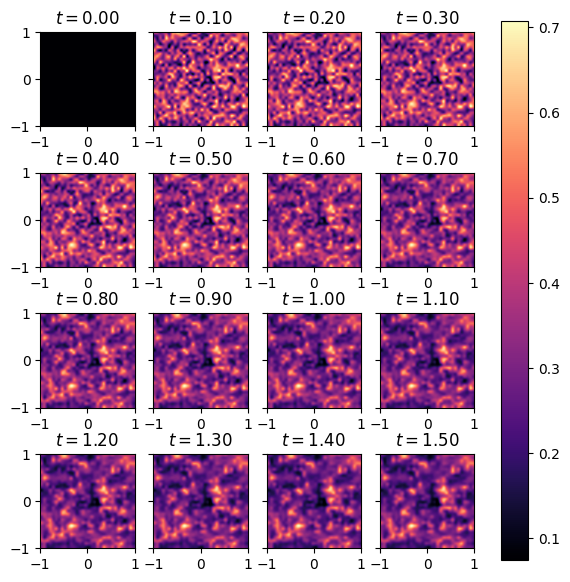

62


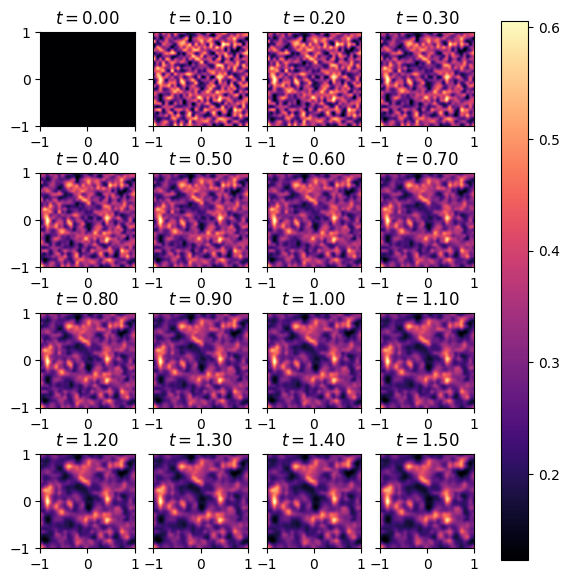

In [30]:
# plot
U = res_x["x"][:, 0].detach().cpu().numpy()
U_Y = Y[:, 0].detach().cpu().numpy()

sample_idx = np.random.randint(0, U.shape[0])
    
fig, axes = plt.subplots(4, 4, figsize=(7, 7), sharey=True)
print(sample_idx)
for i in range(16):
    ax = axes.flat[i]
    time_index = i*int(U.shape[-1]/15)
    field = U[sample_idx, :,:,time_index] - U_Y[sample_idx, :,:,time_index]
    pos = ax.imshow(field, cmap="magma", interpolation='spline16', extent=[-1, 1, -1, 1])
    ax.set_title(f'$t={reactdiff_solver.t[time_index]:.2f}$')

fig.colorbar(pos, ax=axes.ravel().tolist())
plt.show()

fig, axes = plt.subplots(4, 4, figsize=(7, 7), sharey=True)
sample_idx = sample_idx + 1
print(sample_idx)
for i in range(16):
    ax = axes.flat[i]
    time_index = i*int(U.shape[-1]/15)
    field = U[sample_idx, :,:,time_index] - U_Y[sample_idx, :,:,time_index]
    pos = ax.imshow(field, cmap="magma", interpolation='spline16', extent=[-1, 1, -1, 1])
    ax.set_title(f'$t={reactdiff_solver.t[time_index]:.2f}$')
fig.colorbar(pos, ax=axes.ravel().tolist())
plt.show()